# Evaluate Signal Preservation Performance


***Created on 04/24/2023***

***@author: jane***


This notebook reproduces the out-of-batch nearest neighbor composition analysis. The data we use for this tutorial is from a type 1 diabetes by [***Maria Fasolino et al. (2022)***](https://www.nature.com/articles/s42255-022-00531-x), and it can be downloaded from [here](https://cellxgene.cziscience.com/collections/51544e44-293b-4c2b-8c26-560678423380). We have subsampled 30,000 cells for illustration purposes.

In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import harmonypy as hm
import scanpy.external as sce

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80)
pd.set_option('display.max_columns', None)
seed = 10
np.random.seed(seed)

## 1. Load data

In [2]:
adata = sc.read_h5ad('t1d_example_30000.h5ad')

CellANOVA preprocessing.

In [3]:
adata_prep = cnova.model.preprocess_data(adata, integrate_key='dataidx')

/Users/zzj/opt/anaconda3/envs/cnova-env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## 2. CellANOVA pipeline

Control pool construction.

In [4]:
integrate_key = 'dataidx'
condition_key = 'PseudoState'
control_name = 'Control'
control_batches = list(set(adata_prep[adata_prep.obs[condition_key]==control_name,].obs[integrate_key]))
control_dict = {
    'g1': control_batches,
}
control_dict

{'g1': ['HPAP044',
  'HPAP037',
  'HPAP040',
  'HPAP035',
  'HPAP022',
  'HPAP036',
  'HPAP039',
  'HPAP026',
  'HPAP042',
  'HPAP034',
  'HPAP047']}

Model fitting.

In [5]:
adata_prep= cnova.model.calc_ME(adata_prep, integrate_key='dataidx')
adata_prep = cnova.model.calc_BE(adata_prep, integrate_key, control_dict)
adata_prep = cnova.model.calc_TE(adata_prep, integrate_key)

2023-04-24 13:33:41,990 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-24 13:33:50,374 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-24 13:33:50,504 - harmonypy - INFO - Iteration 1 of 30
2023-04-24 13:33:58,792 - harmonypy - INFO - Iteration 2 of 30
2023-04-24 13:34:06,491 - harmonypy - INFO - Iteration 3 of 30
2023-04-24 13:34:14,443 - harmonypy - INFO - Iteration 4 of 30
2023-04-24 13:34:22,348 - harmonypy - INFO - Iteration 5 of 30
2023-04-24 13:34:28,878 - harmonypy - INFO - Iteration 6 of 30
2023-04-24 13:34:33,859 - harmonypy - INFO - Iteration 7 of 30
2023-04-24 13:34:38,374 - harmonypy - INFO - Converged after 7 iterations


Save integrated results.

In [6]:
adata_prep.write_h5ad('t1d_example_30000_integrated.h5ad')

## 3. Signal detection via out-of-batch nearest neighbors

The strategy to evalute a method's effectiveness in preserving biologically meaningful signals is as follows. 

- We first used batch-corrected embeddings to identify thirty out-of-batch nearest neighbors of each cell. 
- Next, we computed the proportions of these nearest-neighbor cells coming from each treatment group and drew smooth densities of these nearest-neighbor compositions. 
- If a batch correction method preserves treatment-specific signals, cells from a specific treatment group should mostly be surrounded by cells from the same treatment group. In other words, we expect a cell in a batch from a specific treatment group to have an enrichment of cells from other batches from the same treatment group in its neighborhood. 
- Additionally, since we only compute out-of-batch nearest neighbors, this local structure is not induced by batch effect, so failure to remove batch effect won't lead to such enrichment.

Load integrated results.

In [7]:
#adata_prep = sc.read_h5ad('t1d_example_30000_integrated.h5ad')
integrated = ad.AnnData(adata_prep.layers['denoised'], dtype=np.float32)
integrated.obs = adata_prep.obs.copy()
integrated.var_names = adata_prep.var_names

We will focus on ductal cell's neighborhood composition.

In [8]:
subset = integrated[integrated.obs['celltype'].isin(['duct_major'])]
subset

View of AnnData object with n_obs × n_vars = 2560 × 3000
    obs: 'dataidx', 'celltype', 'disease_state', 'celltype_orig', 'donor_id', 'disease', 'assay', 'sex', 'ethnicity', 'development_stage', 'PseudoState'

We use function `calc_oobNN` in the `cnova.utils` module to compute out-of-batch nearest-neighbor composition for each cell. The output from this function is still a anndata, with a new `obsm` components `knn_prop`. We then create a dataframe for visualization.

In [9]:
res = cnova.utils.calc_oobNN(subset, batch_key='dataidx', condition_key='PseudoState')
df = res.obsm['knn_prop']
df['condition'] = res.obs['PseudoState']
df = df.reset_index()
df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
df = df.rename(columns={'index': 'obs_name'})
df

,obs_name,condition,neighbor,proportion
0,CTAACTTCAATTCCTT-12,AAB,AAB,0.142857
1,TATCTCACAACTTGAC-12,AAB,AAB,0.071429
2,CGAGCCACACTAAGTC-12,AAB,AAB,0.071429
3,TACTTGTTCGTCCGTT-12,AAB,AAB,0.071429
4,AGCGTATGTATGAATG-12,AAB,AAB,0.000000
...,...,...,...,...
7675,GAGTTTGTCTTGGCTC-11,Control,T1D,0.000000
7676,AGGGCTCCAGTCTGGC-11,Control,T1D,0.000000
7677,CGGCAGTGTATACCTG-19,AAB,T1D,0.071429
7678,ACTTATCCACCTGTCT-19,AAB,T1D,0.000000


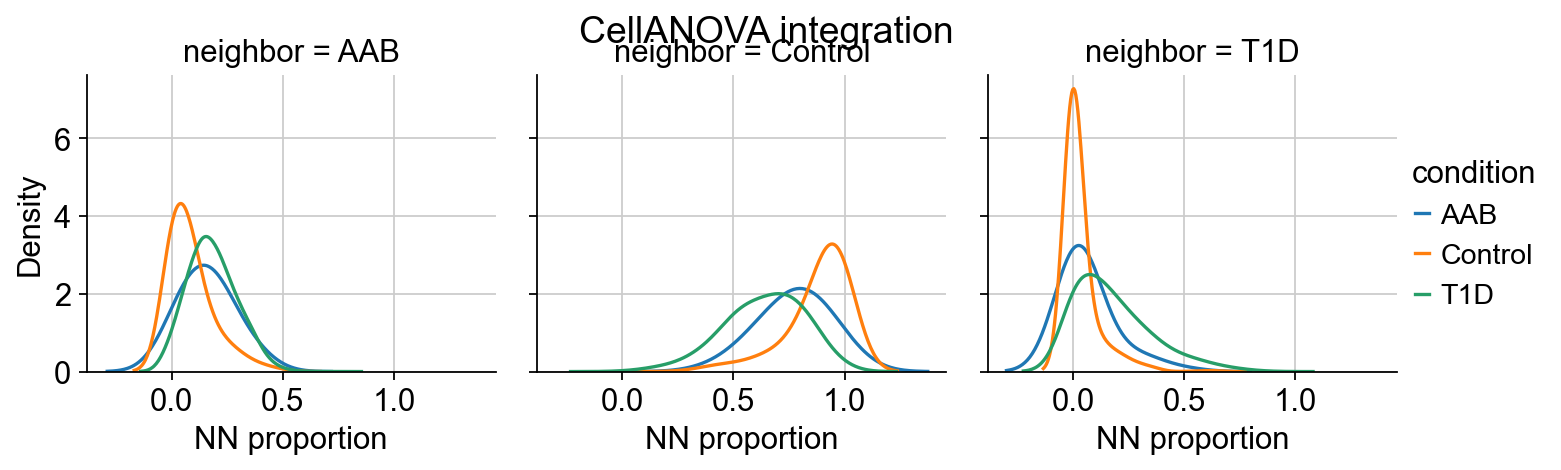

In [10]:
g = sea.FacetGrid(df, col='neighbor', hue='condition')
g.map(sea.kdeplot, 'proportion', bw_adjust=2, alpha=1)
g.set(xlabel='NN proportion', ylabel='Density')
g.add_legend()
plt.suptitle('CellANOVA integration')
sea.set_style('white')
plt.show()

## 4. Apply the signal detection method to other method

In [11]:
rna_temp = ad.AnnData(adata_prep.layers['scale'], dtype = np.float32)
rna_temp.var_names = adata_prep.var_names
rna_temp.obs = adata_prep.obs.copy()
sc.tl.pca(rna_temp)
sce.pp.harmony_integrate(rna_temp, 'dataidx')
harmony = ad.AnnData(rna_temp.obsm['X_pca_harmony'] @ rna_temp.varm['PCs'].T, dtype = np.float32)
harmony.var_names = rna_temp.var_names
harmony.obs = rna_temp.obs.copy()

2023-04-24 13:38:33,173 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-24 13:38:41,505 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-24 13:38:41,622 - harmonypy - INFO - Iteration 1 of 10
2023-04-24 13:38:51,148 - harmonypy - INFO - Iteration 2 of 10
2023-04-24 13:39:01,208 - harmonypy - INFO - Iteration 3 of 10
2023-04-24 13:39:11,083 - harmonypy - INFO - Iteration 4 of 10
2023-04-24 13:39:20,888 - harmonypy - INFO - Iteration 5 of 10
2023-04-24 13:39:30,319 - harmonypy - INFO - Iteration 6 of 10
2023-04-24 13:39:38,139 - harmonypy - INFO - Iteration 7 of 10
2023-04-24 13:39:43,025 - harmonypy - INFO - Converged after 7 iterations


In [12]:
subset = harmony[harmony.obs['celltype'].isin(['duct_major'])]
res = cnova.utils.calc_oobNN(subset, batch_key='dataidx', condition_key='PseudoState')
df = res.obsm['knn_prop']
df['condition'] = res.obs['PseudoState']
df = df.reset_index()
df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
df = df.rename(columns={'index': 'obs_name'})
df

,obs_name,condition,neighbor,proportion
0,CTAACTTCAATTCCTT-12,AAB,AAB,0.214286
1,TATCTCACAACTTGAC-12,AAB,AAB,0.142857
2,CGAGCCACACTAAGTC-12,AAB,AAB,0.142857
3,TACTTGTTCGTCCGTT-12,AAB,AAB,0.214286
4,AGCGTATGTATGAATG-12,AAB,AAB,0.214286
...,...,...,...,...
7675,GAGTTTGTCTTGGCTC-11,Control,T1D,0.142857
7676,AGGGCTCCAGTCTGGC-11,Control,T1D,0.285714
7677,CGGCAGTGTATACCTG-19,AAB,T1D,0.071429
7678,ACTTATCCACCTGTCT-19,AAB,T1D,0.000000


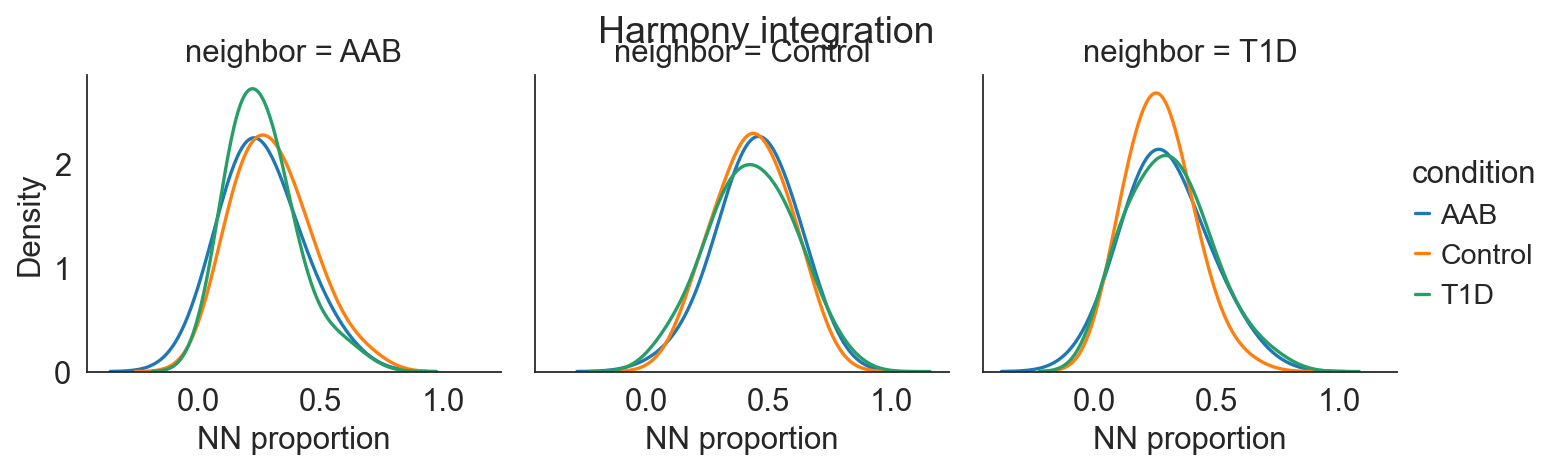

In [13]:
g = sea.FacetGrid(df, col='neighbor', hue='condition')
g.map(sea.kdeplot, 'proportion', bw_adjust=2, alpha=1)
g.set(xlabel='NN proportion', ylabel='Density')
g.add_legend()
plt.suptitle('Harmony integration')
sea.set_style('white')
plt.show()